<a href="https://colab.research.google.com/github/Sonica-B/Machine-Learning-CS539-F24/blob/hw4/hw4_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch with the MNIST Dataset - MINST

In [65]:
## import libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [66]:
print(torch.__version__)

2.5.0+cu121


In [67]:
args={}
kwargs={}
args['batch_size']=64 #changed from 32 to 64
args['test_batch_size']=64
args['epochs']=1  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.01 #Learning rate is how fast it will decend.
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True #if the computer has a GPU, type True, otherwise, False

This code is adopted from the pytorch examples repository. It is licensed under BSD 3-Clause "New" or "Revised" License. Source: https://github.com/pytorch/examples/ LICENSE: https://github.com/pytorch/examples/blob/master/LICENSE

## Load Dataset
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).


In [68]:
## transformations
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

## download and load training dataset
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True, **kwargs)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)

## Exploring the Data


Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset.

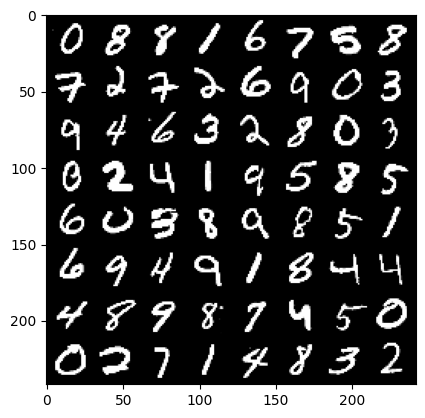

In [69]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [70]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## The Model




---

Function Without CNN Layer 🔽

In [64]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x=x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)



---

Function With 1 CNN Layer 🔽

In [71]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer: 1 input channel, 32 output channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x=x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


---
Function With 2 CNN Layer 🔽


In [55]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer: 1 input channel, 28 output channels
        self.conv1 = nn.Conv2d(1, 28, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 28 input channels, 32 output channels
        self.conv2 = nn.Conv2d(28, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        # Dimensionality reduction layer to match 784 inputs for fc1
        self.dim_reducer = nn.Linear(1568, 784)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x=x.view(-1,784)
        # Apply dimensionality reduction to match input size of fc1
        x = self.dim_reducer(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)

In [72]:
## test the model with 1 batch
model = Net()
#print(model)
for images, labels in train_loader:
    print("batch size:", args['batch_size'])
    out = model(images)
    print(out.shape)
    break

batch size: 64
torch.Size([64, 10])


## Training the Model
Now we are ready to train the model.

In [73]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [74]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if args['cuda']:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

---
### Results - Without CNN Layer 🔽

In [11]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320207
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.004853
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.742395
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.367994
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.218946
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.966231
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.834849
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.647816
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.663867
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.536120
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.643585
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.634093
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.555330
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.452556
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.601981
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.471001
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.528277
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.426070
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.525767
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.447959
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2561, Accuracy: 9262/10000 (93%)



---
### Results - With 1 CNN Layer 🔽

In [ ]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324679
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.801129
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.220307
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.798972
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.553820
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.446185
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.432305
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.603873
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.542304
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.427222
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.399443
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.366460
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.420878
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.332036
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.364819
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.280376
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.412950
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.326366
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.368769
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.204294
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1375, Accuracy: 9593/10000 (96%)



---
## Experimenting with different set of HyperParameters and Network Topologies

1) Results - With 2 CNN Layer 🔽

In [44]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303020
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.281819
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.252346
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.223011
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.154228
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.051044
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.949421
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.595366
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.228488
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.982484
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.724905
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.729990
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.590910
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.889242
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.359823
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.503985
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.554815
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.372829
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.392720
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.353639
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1077, Accuracy: 9660/10000 (97%)



2) Results - lr = 0.05, epochs = 10, batch_size = 32  🔽

In [59]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=args['momentum'])

for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301962
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.208472
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.628933
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.110343
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.140816
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.698782
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.438318
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.517358
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.565106
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.205390
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.170630
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.121782
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.281034
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.279285
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.298693
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.666171
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.111941
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.082327
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.310517
Train Epoch: 1 [6080/60000 (10%)]	Loss: 0.180887
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.09

3) Results - lr = 1, epochs = 10, batch_size = 64  🔽

In [75]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=1, momentum=args['momentum'])

for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340626
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.621990
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.327994
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.329976
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.336680
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.313088
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.318086
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.303602
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.281194
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.307733
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.295525
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.291606
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.293540
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.309397
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.319022
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.320952
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.307073
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.319166
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.301012
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.311115
Train Epoch: 1 [12800/60000 (

# 1.   Through the experiment, what is the best configuration?
Through experimentation, the best-performing configuration included two convolutional layers followed by two fully connected layers. This setup was further optimized with the following hyperparameters:

*   Learning Rate: 0.05
*   Batch Size: 32
*   Epochs: 10

This configuration achieved the highest test accuracy at 98% and the lowest test loss.

* **Two Convolutional Layers:** By using two convolutional layers, the network
could better capture both low-level features (like edges and textures) and higher-level patterns (like curves and shapes). This made it more capable of distinguishing between visually similar digits. Adding layers improved the model’s capacity without significantly increasing the risk of overfitting, as each layer was still focused on extracting different levels of spatial hierarchies.

* **Learning Rate:** A learning rate of 0.05 enabled efficient and stable learning. An excessively high learning rate would risk overshooting optimal parameters, potentially leading to underfitting, while a lower rate could cause slow convergence or even overfitting as it “memorizes” instead of generalizing.

* **Batch Size and Epochs:** The combination of a smaller batch size (32) and more epochs (10) allowed for frequent parameter updates and enough cycles for convergence without excessive training, which could lead to overfitting.

# 2.   What prediction accuracy on the test set you got?
Using this optimized configuration, the test set accuracy reached 98%, which was an improvement over the initial configuration with only fully connected layers that achieved 93%. Observing this accuracy on unseen data suggests that the model generalized well, as it avoided common pitfalls like overfitting, where a model performs well on training data but poorly on test data.

* **Overfitting:** In this case, the model showed resilience against overfitting despite the added layers. This may be due to the structured architecture of CNNs, which are less prone to overfitting compared to fully connected networks, especially for image tasks. Convolutional layers apply weight sharing and pooling, making the model learn spatial hierarchies instead of memorizing individual pixels.

* **Underfitting:** Initially, the simpler model (with only fully connected layers) exhibited signs of underfitting. It struggled to capture the complex patterns necessary for digit recognition, resulting in a lower test accuracy. Adding convolutional layers helped mitigate this issue by enabling the model to learn a broader range of features, ultimately improving test performance.

# 3.   What did you learn?
This experiment underlined several fundamental machine learning principles such as below:

* **Effectiveness of CNN Layers:** Adding convolutional layers significantly improved the model's ability to capture features in the MNIST images, leading to higher accuracy compared to a model with only fully connected layers.

* **Hyperparameter Tuning:** The optimal combination of learning rate, batch size, and the number of epochs played a crucial role in achieving the best results. For example, increasing the number of epochs and using a smaller batch size allowed the model to learn the data distribution better.

* **Importance of Experimentation:** Testing different network topologies and hyperparameters demonstrated how small adjustments can lead to significant improvements in accuracy, underscoring the importance of experimentation in model optimization.





